# HW2: Bayesian GLMs

In this assignment, you will develop Bayesian inference algorithms for generalized linear (mixed) models (GL(M)Ms). We'll put football aside and focus on another timely subject: US presidential elections. We have downloaded data from the [MIT Election Data Science Lab](https://electionlab.mit.edu/data) consisting of presidential votes for each county in the US from 2000-2020. We have also downloaded demographic covariates from 2018 for each county. In this assignment, you will develop models to predict county-level votes given demographic data. 

## Setup

In [1]:
%%capture
!pip install jaxtyping
!pip install kaleido

In [2]:
import json
import torch
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px

from fastprogress import progress_bar
from IPython.display import Image
from jaxtyping import Float, Array
from urllib.request import urlopen
from torch.distributions import Binomial, Gamma, MultivariateNormal, Normal

/Users/scott/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load the vote data

_Note: we did a little preprocessing of the raw data from the MIT Election Data Science Lab to extract counties that have both election and demographic data._

The vote data consists of votes per candidate for each county in the US for presidential elections from 2000 to 2020. Each county is identified by its [FIPS code](https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt). The FIPS code is a five digit integer representing the state and county within the state. We represent the FIPS code as a string since some codes start with zero.

**Note**: Broomfield County CO (FIPS code 08014) did not exist in 2000


In [21]:
votes = pd.read_csv("https://raw.githubusercontent.com/slinderman/stats305b/winter2024/assignments/hw2/votes.csv")
votes.fips = votes.fips.apply(lambda x: str(int(x)).zfill(5))
votes

,year,state,state_po,county_name,fips,candidate,party,totalvotes,candidatevotes
0,2000,ALABAMA,AL,AUTAUGA,01001,AL GORE,DEMOCRAT,17208,4942
1,2000,ALABAMA,AL,AUTAUGA,01001,GEORGE W. BUSH,REPUBLICAN,17208,11993
2,2000,ALABAMA,AL,AUTAUGA,01001,OTHER,OTHER,17208,113
3,2000,ALABAMA,AL,AUTAUGA,01001,RALPH NADER,GREEN,17208,160
4,2000,ALABAMA,AL,BALDWIN,01003,AL GORE,DEMOCRAT,56480,13997
...,...,...,...,...,...,...,...,...,...
63206,2020,WYOMING,WY,WASHAKIE,56043,OTHER,OTHER,4032,71
63207,2020,WYOMING,WY,WESTON,56045,DONALD J TRUMP,REPUBLICAN,3560,3107
63208,2020,WYOMING,WY,WESTON,56045,JO JORGENSEN,LIBERTARIAN,3560,46
63209,2020,WYOMING,WY,WESTON,56045,JOSEPH R BIDEN JR,DEMOCRAT,3560,360


### Load the demographic data

We also have county-level demographic data for all counties except those in Alaska. The data was collected in 2018. The fields of the table are described [here](https://github.com/MEDSL/2018-elections-unoffical/blob/master/election-context-2018.md). Note that each county has a matching FIPS code, again represented as a five digit string.

In [22]:
demo = pd.read_csv("https://raw.githubusercontent.com/slinderman/stats305b/winter2024/assignments/hw2/demographics.csv")
demo.fips = demo.fips.apply(lambda x: str(int(x)).zfill(5))
demo

,state,county,trump16,clinton16,otherpres16,romney12,obama12,otherpres12,demsen16,repsen16,...,age65andolder_pct,median_hh_inc,clf_unemploy_pct,lesshs_pct,lesscollege_pct,lesshs_whites_pct,lesscollege_whites_pct,rural_pct,ruralurban_cc,fips
0,Alabama,Autauga,18172,5936,865,17379,6363,190,6331.0,18220.0,...,13.978456,53099.0,5.591657,12.417046,75.407229,10.002112,74.065601,42.002162,2.0,01001
1,Alabama,Baldwin,72883,18458,3874,66016,18424,898,19145.0,74021.0,...,18.714851,51365.0,6.286843,9.972418,70.452889,7.842227,68.405607,42.279099,3.0,01003
2,Alabama,Barbour,5454,4871,144,5550,5912,47,4777.0,5436.0,...,16.528895,33956.0,12.824738,26.235928,87.132213,19.579752,81.364746,67.789635,6.0,01005
3,Alabama,Bibb,6738,1874,207,6132,2202,86,2082.0,6612.0,...,14.885699,39776.0,7.146827,19.301587,88.000000,15.020490,87.471774,68.352607,1.0,01007
4,Alabama,Blount,22859,2156,573,20757,2970,279,2980.0,22169.0,...,17.192916,46212.0,5.953833,19.968585,86.950243,16.643368,86.163610,89.951502,1.0,01009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3106,Wyoming,Sweetwater,12154,3231,1745,11428,4774,693,NaN,NaN,...,9.417120,68233.0,5.072255,9.314606,78.628507,6.238463,76.606813,10.916313,5.0,56037
3107,Wyoming,Teton,3921,7314,1392,4858,6213,393,NaN,NaN,...,11.837510,75594.0,2.123447,4.633570,46.211584,1.526877,41.769504,46.430920,7.0,56039
3108,Wyoming,Uinta,6154,1202,1114,6615,1628,296,NaN,NaN,...,10.678218,53323.0,6.390755,10.361224,81.793082,8.806312,81.080852,43.095937,7.0,56041
3109,Wyoming,Washakie,2911,532,371,3014,794,136,NaN,NaN,...,19.650341,46212.0,7.441860,12.577108,78.923920,10.299738,75.980688,35.954529,7.0,56043


In [5]:
demo.columns

Index(['state', 'county', 'trump16', 'clinton16', 'otherpres16', 'romney12',
       'obama12', 'otherpres12', 'demsen16', 'repsen16', 'othersen16',
       'demhouse16', 'rephouse16', 'otherhouse16', 'demgov16', 'repgov16',
       'othergov16', 'repgov14', 'demgov14', 'othergov14', 'total_population',
       'cvap', 'white_pct', 'black_pct', 'hispanic_pct', 'nonwhite_pct',
       'foreignborn_pct', 'female_pct', 'age29andunder_pct',
       'age65andolder_pct', 'median_hh_inc', 'clf_unemploy_pct', 'lesshs_pct',
       'lesscollege_pct', 'lesshs_whites_pct', 'lesscollege_whites_pct',
       'rural_pct', 'ruralurban_cc', 'fips'],
      dtype='object')

### Helper function for plotting

We provide a simple function to plot values associated with each county. 

In [13]:
with urlopen("https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json") as response:
    geojson = json.load(response)

def plot_counties(fips, values, label="", cmap="RdBu", interactive=True):
    fig = px.choropleth(pd.DataFrame(dict(fips=fips, values=values)), 
                        geojson=geojson, 
                        locations="fips", 
                        color="values",
                        color_continuous_scale=cmap,
                        scope="usa",
                        labels={"values":label})
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    if interactive:
        return fig
    else:
        return Image(fig.to_image(scale=2.0))

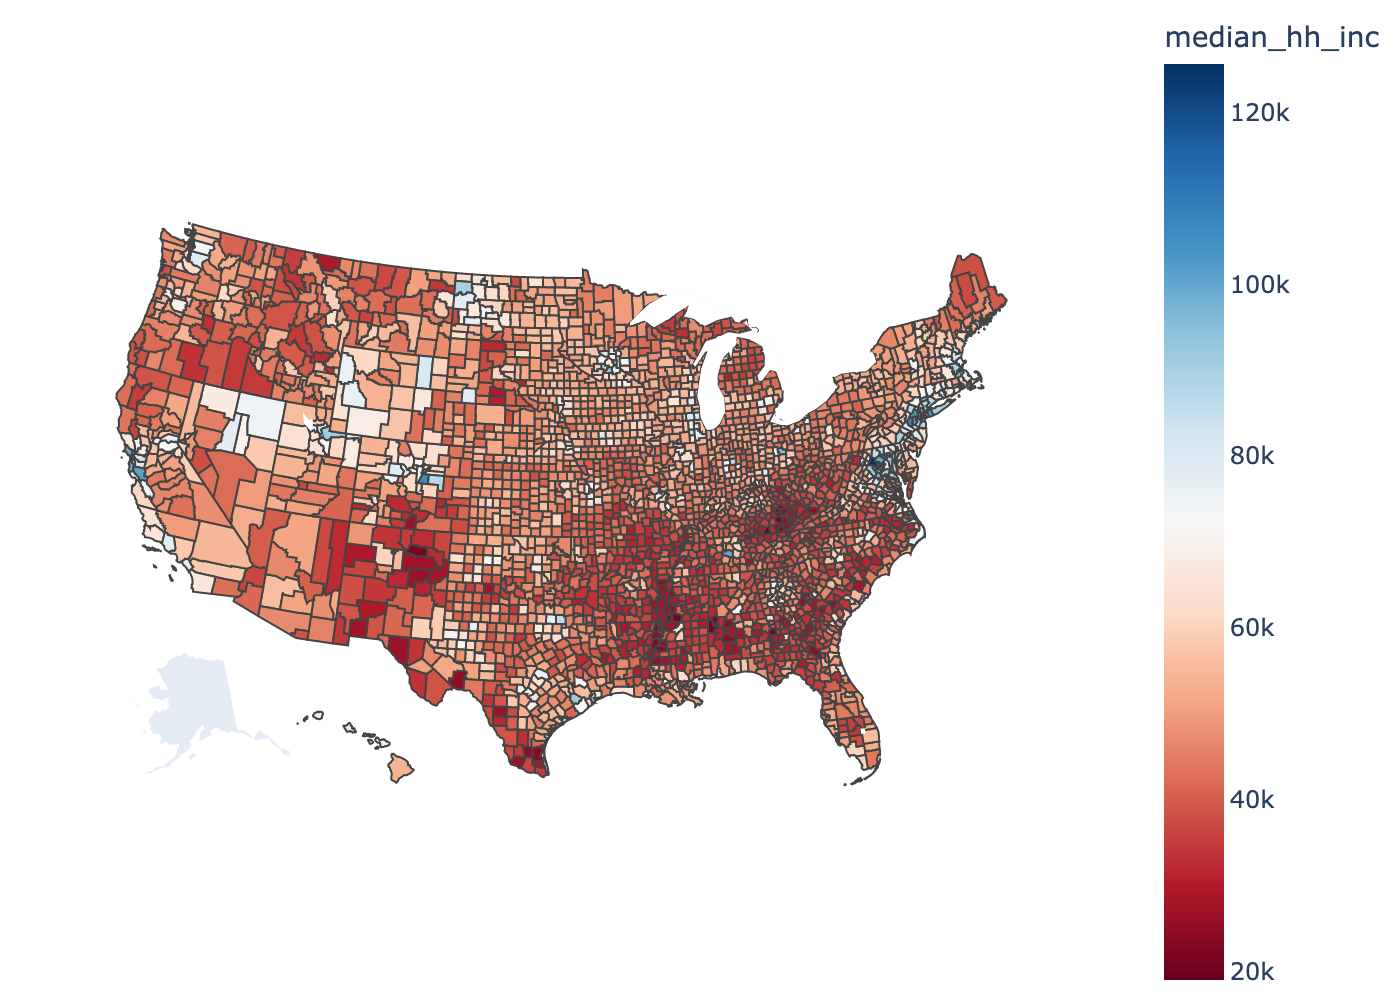

In [14]:
# Demo of how to plot. 
# Note: you can use interactive plots in Colab. I turned off interactive mode
#   because the interactive plots don't renter in the online book.
plot_counties(demo.fips, 
              demo.median_hh_inc, 
              label="median_hh_inc", 
              cmap="RdBu", 
              interactive=False)

## Part 0: Preprocessing

There are $n=3111$ counties and $m=6$ presidential elections in this dataset. 

Let 
- $y_{i,k} \in \mathbb{N}$ denote the number of votes for the **Democratic Party candidate** in county $i$ and election $k$ for $i=1,\ldots,n$ and $k=1,\ldots,m$.
- $N_{i,k} \in \mathbb{N}$ denote the **total number of votes** cast in county $i$ and election $k$ for $i=1,\ldots,n$ and $k=1,\ldots,m$.  
- $\mathbf{x}_i \in \mathbb{R}^p$ denote the vector of demographic covariates for county $i$ from the table above.

We will use the following covariates:
- `white_pct`
- `black_pct`
- `hispanic_pct`
- `foreignborn_pct`
- `female_pct`
- `age29andunder_pct`
- `age65andolder_pct`
- `median_hh_inc`
- `clf_unemploy_pct`
- `lesshs_pct`
- `lesscollege_pct`
- `lesshs_whites_pct`
- `lesscollege_whites_pct`
- `rural_pct`
- `ruralurban_cc`

### Problem 0a

Extract PyTorch tensors for the Democratic votes ($n \times m$ tensor), total votes ($n \times m$ tensor), and covariates ($n \times p$ tensor).

**Notes:**
- Set the first covariate to $x_{i,1} = 1$ for all $i=1,\ldots,n$ in order to allow for an intercept.
- Make sure real-valued covariates are standardized to be mean-zero, unit standard deviation across counties.
- Use a one-hot encoding for categorical covariates, omitting the last category. For example, if a covariate $X$ takes on discrete values $\{1, \ldots, C\}$, encode it as a vector $v$ of length $C-1$ where $v_j = \mathbb{I}[X=j]$.



### Problem 0b: One-hot encodings

Explain why we omitted the laset category in the encoding of categorical covariates.

### Problem 0c: Other covariates

Explain why we didn't include `nonwhite_pct` in our set of covariates.

## Part 1: Bayesian Inference in a Binomial GLM via Polya-gamma augmentation

Start with a simple baseline model,
\begin{align*}
y_{i,k} &\sim \mathrm{Bin}(N_{i,k}, \, \sigma(x_i^\top \beta))
& \text{for } &i=1,\ldots,n; \, k=1,\ldots,m \\
\beta &\sim \mathrm{N}(0, I)
\end{align*}
where $\sigma$ is the logistic function.

The Polya-gamma (PG) augmentation trick {cite:p}`polson2013bayesian` is based on the following identity,
\begin{align*}
\frac{(e^u)^y}{(1 + e^u)^N} = 2^{-N} e^{(y - \frac{N}{2}) u} \int e^{-\frac{1}{2} \omega u^2} \, \mathrm{PG}(\omega; N, 0) \, \mathrm{d} \omega,
\end{align*}
where $\mathrm{PG}(\omega; b, c)$ denotes the Polya-gamma density. The PG distribution has support on the non-negative reals, and it parameterized by a _shape_ $b \geq 0$ and a _tilt_ $c \in \mathbb{R}$. 

The PG distribution isn't exactly textbook, but it has many nice properties. For instance, PG random variables are equal in distribution to a weighted sum of gamma random variables. If $\omega \sim \mathrm{PG}(b, c)$ then,
\begin{align*}
\omega \overset{d}{=} \frac{1}{2 \pi^2} \sum_{k=1}^\infty \frac{g_k}{(k - \tfrac{1}{2})^2 + \tfrac{c^2}{4 \pi^2}}
\end{align*}
where $g_k \overset{\mathrm{iid}}{\sim} \mathrm{Ga}(b, 1)$. Since the coefficients in this sum are decreasing with $k$, we can draw an approximate sample from a PG distribution by truncating the sum. Since the PG distribution doesn't exist in PyTorch, we have provided a helper function below to draw samples from the PG distribution.

**Notes:** 
- As $b \to 0$, the PG density converges to a delta function at zero. This is useful when you have missing data.
- There are more efficient ways to sample PG random variables. See {cite:t}`windle2014sampling` and [https://github.com/slinderman/pypolyagamma](https://github.com/slinderman/pypolyagamma). The naive sampling code below should work for this assignment though.


In [11]:
def sample_pg(b: Float[Array, "..."], 
              c: Float[Array, "..."], 
              trunc: int=200) -> \
              Float[Array, "..."]:
    """
    Sample X ~ PG(b, c) the naive way using a weighted sum of gammas.
    Note: there are much more efficient sampling methods. See 

    Windle, Jesse, Nicholas G. Polson, and James G. Scott. "Sampling 
        Pólya-gamma random variates: alternate and approximate techniques." 
        arXiv preprint arXiv:1405.0506 (2014).
        https://arxiv.org/abs/1405.0506

    and https://github.com/slinderman/pypolyagamma

    Arguments
    ---------
    b: tensor of arbitrary shape specifying the "shape" argument of 
        the PG distribution.

    c: tensor of arbitrary shape specifying the "tilt" argument of 
        the PG distribution. Must broadcast with b.

    Returns
    -------
    tensor of independent draws of PG(b, c) matching the shapes of b and c.
        
    """
    # make sure the parameters are float tensors and broadcast compatible
    b = b if isinstance(b, torch.Tensor) else torch.tensor(b) 
    c = c if isinstance(c, torch.Tensor) else torch.tensor(c) 
    b = b.float()
    c = c.float()
    b, c = torch.broadcast_tensors(b, c)

    # Draw the PG random variates
    g = Gamma(b + 1e-8, 1.0).sample((trunc,))                          # (trunc, b.shape)
    g = torch.moveaxis(g, 0, -1)                                       # (b.shape, trunc)
    k = torch.arange(trunc) + 1
    w = 1 / ((k - 0.5)**2 + c[...,None]**2 / (4 * torch.pi**2))        # (c.shape, trunc)
    return 1 / (2 * torch.pi**2) * torch.sum(g * w, axis=-1)           # (b.shape,)

Text(0.5, 1.0, 'samples of PG(1,0) distribution')

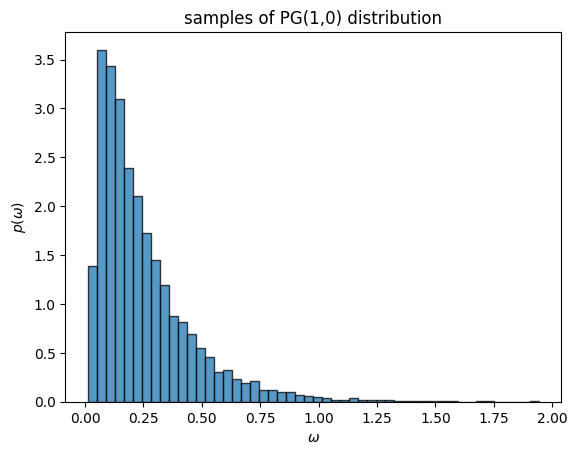

In [12]:
omegas = sample_pg(torch.ones(10000), torch.zeros(10000))
_ = plt.hist(omegas, 50, density=True, alpha=0.75, edgecolor='k')
plt.xlabel(r"$\omega$")
plt.ylabel(r"$p(\omega)$")
plt.title("samples of PG(1,0) distribution")

### Problem 1a
Use the integral identity above to write the distribution $p(y, \beta \mid X)$ as a marginal of a distribution over an augmented space, $p(y, \beta, \omega \mid X)$. (Note that we are using the shorthand $y$ for the set of all responses.)

### Problem 1b

The nice thing about this augmented distribution is that it has simple conditional distributions, which allows for a simple Gibbs sampling algorithm to approximate the posterior distribution.

Derive the conditional distribution, $p(\beta \mid y, X, \omega)$. 

### Problem 1c

One nice property of the Polya-gamma distribution is that it is closed under exponential tilting,
\begin{align*}
e^{-\frac{1}{2} \omega c^2} \mathrm{PG}(\omega; b, 0) &\propto \mathrm{PG}(\omega; b, c).
\end{align*}
(Again, $\mathrm{PG}(\omega; b, c)$ denotes the Polya-gamma pdf.)

Derive the conditional distribution $p(\omega \mid y, X, \beta)$. 

### Problem 1d

Implement a Gibbs sampling algorithm to sample the posterior distribution of the augmented model, $p(\beta, \omega \mid y, X)$. As described in the course notes, Gibbs sampling is a type of MCMC algorithm in which we iteratively draw samples from the conditional distributions. Here, the algorithm is,

> **Input:** Initial weights $\beta^{(0)}$, responses $y$, and covariates $X$.
>
> **For** $t=1,\ldots, T$
> 1. Sample $\omega^{(t)} \sim p(\omega \mid \beta^{(t-1)}, y, X)$
> 2. Sample $\beta^{(t)} \sim p(\beta \mid y, X, \omega^{(t)})$
> 3. Compute log probability $\ell^{(t)} = \log p(y, \beta \mid X)$
>
> **Return** samples $\{\beta^{(t)}\}_{t=1}^T$ and log probabilities $\{\ell^{(t)}\}_{t=1}^T$. 

Implement that algorithm.



### Problem 1e: Posterior analysis

Run your algorithm and **make the following plots**:
1. A trace of the log joint probability $p(y, \beta \mid X)$ across MCMC iterations (i.e., samples of $\beta$).
2. A trace of the sampled values of $\beta_j$ across MCMC iterations. You can plot all the line plots for $j=1,\ldots,p$ on one plot, rather than making a bunch of subplots.
3. A box-and-whiskers plot of sampled values of $\beta_j$ for the covariates $j=1,\ldots,p$. 
4. Discard the first 20 samples of your MCMC algorithm and use the remaining samples to approximate the posterior expectation $\mathbb{E}[\sigma(x_i^\top \beta)]$ for each county $i$. Plot the predictions using the `plot_counties` function given above.

Remember to label your axes!

**Discuss**: How much posterior uncertainty do you find in $\beta$? Why does your result make sense?

## Part 2: Model Checking

Building a model and running an inference algorithm are just the first steps of an applied statistical analysis. Now we need to check the model and see if it offers a good fit to the data. With exponential family GLMs like this one, it's a good idea to check the deviance residuals

### Problem 2a: Binomial deviance residuals

1. Write the binomial pmf, $\mathrm{Bin}(y; N, \pi)$, in exponential family form. 
2. Derive a closed form expression for the KL divergence between two binomial distributions (with the same total count $N$ but different probabilities $\pi$) in terms of the natural parameters.
3. Write the KL divergence in terms of the mean parameters.
4. Derive a closed form expression for the deviance residuals between a observed value $y$ and a predicted value $\hat{y} = N \pi$ in terms of the mean parameters.

### Problem 2b: Residual analysis

Using the posterior mean of $\beta$ approximated with samples of your Markov chain, compute the deviance residuals between the observed vote counts and the expected counts.

1. **Plot:** a histogram of the deviance residuals (across all years and counties). 
2. **Plot:** a scatter plot of deviance residuals for all pairs of election years (you should organize the subplots in a grid). Do you see correlations in the residuals across years? 
3. **Discuss:** Do the deviance residuals look as exoected? If not, discuss why that could be the case.



## Part 3: Generalized Linear Mixed Modeling

According to the model above, the responses (and residuals) should be conditionally independent across counties and election years given the covariates and weights. Correlated residuals can arise from unmodeled factors of variation. For example, perhaps there is some feature of counties that would explain their voting tendencies, but which was not captured in the demographic covariates above. Maybe some geographic regions tend to vote for Democrats or Republicans, even though other regions with similar demographics vote differently. 

**Generalized linear _mixed_ models (GLMMs)** try to capture those unmeasured factors of variation using latent variables. Since we have multiple election years of data for each county, we might expect to be able to model and estimate the correlation in voting tendencies across counties. 

For this problem, you will develop a Bayesian inference algorithm for the following model,
\begin{align*}
y_{i,k} &\sim \mathrm{Bin}(N_{i,k}, \sigma(a_{i,k}))
& \text{for } &i=1,\ldots,n; \, k=1,\ldots,m
\end{align*}
where
\begin{align*}
a_{i,k} &= x_i^\top \beta + z_i \gamma_k.
\end{align*}
Assume the following priors,
\begin{align*}
\beta &\sim \mathrm{N}(0, I) \\
z_i &\sim \mathrm{N}(0, 1) & \text{for } &i=1,\ldots,n \\
\gamma_k &\sim \mathrm{N}(0, 1) & \text{for } &k=1,\ldots,m \\
\end{align*}
This model adds the following components:
- a per-county **latent variable** $z_i \in \mathbb{R}$ 
- a per-year **random effect** $\gamma_k \in \mathbb{R}$ 

Note that while $y_{i,k}$ and $y_{i',k}$ are _conditionally independent_ given the parameters, covariates, and latent variables of the model, they are _marginally dependent_ when we integrate over latent variables. Thus, this model is better suited to capture the county-to-county correlations indicated by the residual analyses above.

Finally, as above, we can use Polya-gamma augmentation to implement a Gibbs sampler for this model.

### Problem 3a

Derive the conditional distribution $p(\beta \mid y, X, z, \gamma, \omega)$ where $\omega$ are PG augmentation variables. 

### Problem 3b

Derive the conditional distribution $p(z \mid y, X, \beta, \gamma, \omega)$ where $\omega$ are PG augmentation variables. 

### Problem 3c

Derive the conditional distribution $p(\gamma \mid y, X, \beta, z, \omega)$ where $\omega$ are PG augmentation variables. 

### Problem 3d

Implement a Gibbs sampler for this binomial generalized linear mixed model using PG augmentation. Run the sampler and make the following plots:
1. A trace of the log joint probability 
2. A trace of the samples of $\beta$.  
3. A box-and-whiskers plot of the samples of $\beta$


### Problem 3e

Plot the deviance residuals like you did in Problem 2b, now using your last MCMC sample of the parameters, latent variables, and random effects. Compared to your results from Problem 2b, is the model improving?

### Problem 3f

Visualize the last MCMC sample of the latent variables $z$ using the `plot_counties` function. Likewise, plot the last sample of the random effects $\gamma$. Can you spectulate what type of unmodeled feature this latent variable is capturing?

## Part 4: Reflection

You just went through two iterations of what some call _Box's Loop_ {cite:p}`blei2014build`: you extracted relevant features from a real world dataset, built an initial model, implemented and ran a Bayesian inference algorithm, inspected the posterior, critiqued the model and revised it accordingly, and then repeated the process. In actual applied statistics problems, we often repeat this process many times as we hone our models and improve our algorithms. 



### Problem 4a
If you were to further refine this model, what change would you make next? Why? How do you hypothesize it would alter your results?


## Submission Instructions

**Formatting:** check that your code does not exceed 80 characters in line width. You can set _Tools &rarr; Settings &rarr; Editor &rarr; Vertical ruler column_ to 80 to see when you've exceeded the limit.

**Converting to PDF** The simplest way to convert to PDF is to use the "Print to PDF" option in your browser. Just make sure that your code and plots aren't cut off, as it may not wrap lines.

**Alternatively** You can download your notebook in .ipynb format and use the following commands to convert it to PDF.  Then run the following command to convert to a PDF:
```
jupyter nbconvert --to pdf <yourlastname>_hw<number>.ipynb
```
(Note that for the above code to work, you need to rename your file `<yourlastname>_hw<number>.ipynb`)

**Installing nbconvert:**

If you're using Anaconda for package management,
```
conda install -c anaconda nbconvert
```

**Upload** your .pdf file to Gradescope. Please tag your questions correctly! I.e., for each question, all of and only the relevant sections are tagged.

Please post on Ed or come to OH if there are any other problems submitting the HW.